In [22]:
#!pip install seaborn
#!pip install openpyxl


In [23]:
import pandas as pd
import numpy as np
import random as rd
import time
import csv
import seaborn as sbs
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import train_test_split ,GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow import data
import tensorflow as tf
from matplotlib import pyplot
from sklearn.metrics import mean_squared_error
from sklearn.metrics import median_absolute_error

In [24]:
#
# #from google.colab import drive
#drive.mount('/content/drive')
file_data = 'DS_Agua_2017_2022_por_ponto.csv'
path_name='data/'
path_name_results='results/'
file_result = 'Result_LSTM_Model_Hour.csv'

In [25]:
dataset = pd.read_csv(f'{path_name}{file_data}', sep =';', encoding = 'latin1', decimal='.')


In [26]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 368849 entries, 1 to 368849
Data columns (total 8 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   DT_MEDICAO_HORA         368849 non-null  object 
 1   PRECIPITACAO            368849 non-null  float64
 2   PRESSAO_ATMOSFERICA     368849 non-null  float64
 3   TEMPERATURA_DO_AR_C     368849 non-null  float64
 4   UMIDADE_RELATIVA_DO_AR  368849 non-null  float64
 5   VELOCIDADE_VENTO        368849 non-null  float64
 6   SK_PONTO                368849 non-null  int64  
 7   VL_MEDICAO              368849 non-null  float64
dtypes: float64(6), int64(1), object(1)
memory usage: 25.3+ MB


In [27]:
#verifica se existe variáveis nulas 
dataset.isna().sum()

DT_MEDICAO_HORA           0
PRECIPITACAO              0
PRESSAO_ATMOSFERICA       0
TEMPERATURA_DO_AR_C       0
UMIDADE_RELATIVA_DO_AR    0
VELOCIDADE_VENTO          0
SK_PONTO                  0
VL_MEDICAO                0
dtype: int64

In [28]:
def salvar_resultado(sk_ponto, ds_best_param, n_time_steps, MSE, RMSE, MAE, MAPE, Duration):
  #Script to write training cycle results
  data = [sk_ponto, ds_best_param, n_time_steps, MSE, RMSE, MAE, MAPE, Duration]
  fields = ['SK_PONTO','Best Params','N_Past_Vl','MSE','RMSE','MAE','MAPE','Duration']
  with open(f'{path_name_results}{file_result}', "a",newline='') as csv_file:
    writer = csv.writer(csv_file,delimiter=';')
    writer.writerow(data)  
  print(fields)
  print(data)
    
#Script to create the results file
def criar_arquivo_resultado():
  fields = ['SK_PONTO','Best Params','N_Past_Vl','MSE','RMSE','MAE','MAPE','Duration']
  with open(f'{path_name_results}{file_result}', "w",newline='') as csv_file:
    writer = csv.writer(csv_file,delimiter=';')
    writer.writerow(fields)    

In [29]:
def imprime_grafico(y_test, predict):
  #O gráfico abaixo mostra os valores reais em preto e os valores prditos em azul
  npredicts=1000
  pyplot.figure(figsize=(10,7)) 
  pyplot.scatter(np.arange(0,y_test.shape[0],1)[0:npredicts],np.array(y_test)[0:npredicts], color = 'black')
  pyplot.plot(np.arange(0,predict.shape[0],1)[0:npredicts], np.array(predict)[0:npredicts], color = 'blue', linewidth=2)
  pyplot.xlabel('n seq.')
  pyplot.ylabel('consumo l/h')
  pyplot.show()

In [36]:
def previsao_MLP(sk_ponto, dataset, n_time_steps):
  # dataframe tratament
  df = pd.DataFrame()
  df['VL_MEDICAO']=dataset['VL_MEDICAO']  

  # time serire transform - shit 1 step time

  for n_step in range(1,n_time_steps+1,1):
    df['vl-'+str(n_step)]=dataset['VL_MEDICAO'].shift(n_step)  
    
  df['tp-1']=dataset['TEMPERATURA_DO_AR_C']
  df['pr-1']=dataset['PRESSAO_ATMOSFERICA']
  df['vv-1']=dataset['VELOCIDADE_VENTO']
  df['ur-1']=dataset['UMIDADE_RELATIVA_DO_AR']
  df['ch-1']=dataset['PRECIPITACAO']  

  df.dropna(inplace=True)
  
  
  
  #Split dataset in treinam /  75% treinam  25% test
  nlinhas = int(np.round(df.shape[0] *0.75)) # 
  
  #max_size_train_split = int(np.round(nlinhas / 5)) 
  #max_size__test_split = int(np.round((df.shape[0] - nlinhas) / 5))
  #size_split = 5
  
  X_train = df.iloc[0:nlinhas,1: 6 + n_time_steps]
  y_train = df.iloc[0:nlinhas,0].values

  X_test = df.iloc[nlinhas:dataset.shape[0],1: 6 + n_time_steps] 
  y_test = df.iloc[nlinhas:dataset.shape[0],0].values
  
  
  # Stores the training execution start time
  Hora_Inicio = time.time()
  
  
  train_feature = np.array(X_train).reshape((X_train.shape[0], 1, X_train.shape[1])) # dados de entrada de treinamento.
  train_label = np.array(y_train).reshape((y_train.shape[0], 1, 1)) # dado de saída esperados no treinamento.  

  N_Nos_Layer1=100 #Número de neurônios do layer 1   # 64
  N_Nos_Layer2=90 # Número de neurônios do layer 2  # 128
  N_Nos_Layer3=96 # Númer ode neurônios do layer 3  

  # Armazena a hora de início da execução do Treinamento
  Hora_Inicio = time.time()
  # Resultados para o batch size encontrados, para 100 epocas, de acordo com a variação do batch size = desta forma o batch size ideal selecionado foi o 4096, considerando que a partir desse ponto o ganho é reduzido drasticamente.
  # 128 = 99s   1024 = 20s   2048 = 13s  4096 = 10s 8192 = 9.53s
  batch_size = 4096
  train_data = data.Dataset.from_tensor_slices((train_feature, train_label))
  train_data = train_data.repeat().batch(batch_size, drop_remainder=True)
  EPOCAS = 200  

  model = keras.Sequential()
  model.add(layers.LSTM(N_Nos_Layer1, batch_input_shape=(batch_size, train_feature.shape[1], train_feature.shape[2]),  return_sequences=True, activation='relu'))  
  model.add(layers.LSTM(N_Nos_Layer2, batch_input_shape=(N_Nos_Layer1, train_feature.shape[1], train_feature.shape[2]), return_sequences=True, activation='relu'))  
  model.add(layers.Dense(N_Nos_Layer3, activation="relu"))
  model.add(layers.Dense(1))

  model.compile(loss='mean_absolute_percentage_error', optimizer='adam', metrics=['mape'])  

  #model.summary()  
  resultado=' LSTM('+ str(N_Nos_Layer1) +','+str(N_Nos_Layer2)+','+str(N_Nos_Layer3)+')'

  #history = model.fit(train_feature, train_label, epochs=EPOCAS,shuffle=True,batch_size=batch_size, verbose=2)
  steps_per_epoch = len(train_feature) // batch_size 
  history = model.fit(train_data, epochs=EPOCAS, steps_per_epoch = steps_per_epoch) 
  
  val_feature = np.array(X_test).reshape((X_test.shape[0], 1, X_test.shape[1]))
  val_label = np.array(y_test).reshape((y_test.shape[0], 1, 1))
  
  
  test_data = data.Dataset.from_tensor_slices((val_feature, val_label))
  test_data = test_data.repeat().batch(batch_size, drop_remainder=True)
  
  predict = model.predict(test_data, steps=1)
  #predict = model.predict(train_data, steps=1)
  
  val_label=val_label[0:len(predict)]
  
  predict = np.array(predict).reshape(4096,1)
  y_test = np.array(val_label).reshape(4096,1)

  # Stores the training execution end time
  Hora_Fim = time.time()  

  #Calculate the duration of the training execution
  Duracao = Hora_Fim - Hora_Inicio  

  #Mean Squared Error (Mean Squared Difference Between Estimated Values and Actual Values) - MSE
  MSE = mean_squared_error(y_test, predict)  

  # Square Root of Mean Error - RMSE
  RMSE = np.sqrt(mean_squared_error(y_test, predict))  

  # Mean Absolute Distance or Mean Absolute Error - MAE
  MAE= median_absolute_error(y_pred=predict, y_true = y_test)  

  #Calculate the MAPE (Mean Absolute Percentage Error)
  MAPE = ((np.mean(np.abs(y_test -predict) / (y_test)))) * 100   
  
  print('sk_ponto=',sk_ponto, 'MAPE=',MAPE)
  
  imprime_grafico(y_test, predict)
  #salvar_resultado(sk_ponto, resultado, n_time_steps, MSE, RMSE, MAE, MAPE, Duracao)
  return model, y_test, predict

In [31]:
#selects the identification points of each reservoir
#df_unique_pontos = dataset['SK_PONTO'].unique()

#create file to results
#criar_arquivo_resultado()

#for sk in np.array(df_unique_pontos):
#    print('forecast for sk_ponto = ',sk)
#    df_ponto = dataset[dataset['SK_PONTO']==sk]
#    df_ponto = df_ponto.drop('SK_PONTO',axis=1)
#    for n_time_steps in range(1,7): #predict with 1 to 6 past values of medition
#        grid = previsao_MLP(sk, df_ponto, n_time_steps)

Epoch 1/200
3/3 [==============================] - 1s 63ms/step - loss: 99.1252 - mape: 99.1252
Epoch 2/200
3/3 [==============================] - 0s 64ms/step - loss: 97.2973 - mape: 97.2973
Epoch 3/200
3/3 [==============================] - 0s 64ms/step - loss: 95.2276 - mape: 95.2276
Epoch 4/200
3/3 [==============================] - 0s 65ms/step - loss: 92.3734 - mape: 92.3734
Epoch 5/200
3/3 [==============================] - 0s 65ms/step - loss: 87.8348 - mape: 87.8348
Epoch 6/200
3/3 [==============================] - 0s 65ms/step - loss: 82.5522 - mape: 82.5522
Epoch 7/200
3/3 [==============================] - 0s 67ms/step - loss: 75.3771 - mape: 75.3771
Epoch 8/200
3/3 [==============================] - 0s 66ms/step - loss: 64.8536 - mape: 64.8536
Epoch 9/200
3/3 [==============================] - 0s 69ms/step - loss: 51.1425 - mape: 51.1425
Epoch 10/200
3/3 [==============================] - 0s 67ms/step - loss: 31.6543 - mape: 31.6543
Epoch 11/200
3/3 [=====================

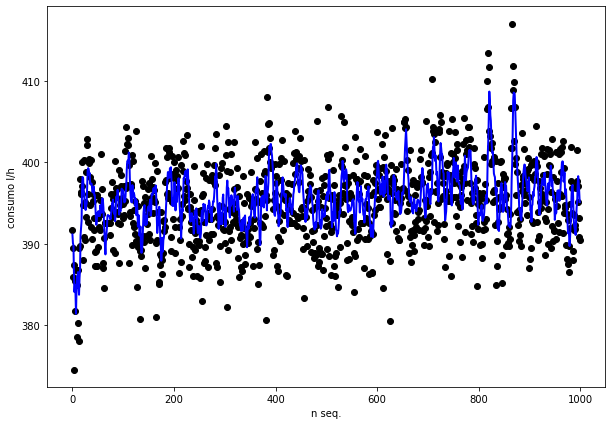

In [37]:


#print graph
sk=9
df_ponto = dataset[dataset['SK_PONTO']==sk]
df_ponto = df_ponto.drop('SK_PONTO',axis=1)
n_time_steps=5
model, y_test, pedict = previsao_MLP(sk, df_ponto, n_time_steps)


In [46]:
predict=pedict

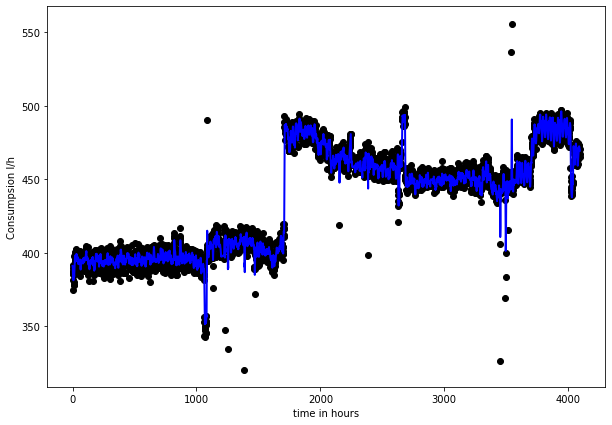

In [55]:
  npredicts=4096
  pyplot.figure(figsize=(10,7)) 
  pyplot.scatter(np.arange(0,y_test.shape[0],1)[0:npredicts],np.array(y_test)[0:npredicts], color = 'black')
  pyplot.plot(np.arange(0,predict.shape[0],1)[0:npredicts], np.array(predict)[0:npredicts], color = 'blue', linewidth=2)
  pyplot.xlabel('time in hours')
  pyplot.ylabel('Consumpsion l/h')
  pyplot.savefig('../Orientacao/artigo01/Latex/figures/FIG7.jpg',dpi=1000)
  pyplot.show()

In [53]:
pyplot.savefig('../Orientacao/artigo01/Latex/figures/FIG7.jpg',dpi=1000)

<Figure size 432x288 with 0 Axes>